# Data Loading Demo

Minimal demo showing how to load and use the TemperatureDataset.

In [137]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch

sys.path.insert(0, "../src")

from lasernet.temperature.data import TemperatureDataset

## Load Dataset

In [117]:
# Create dataset for training split
dataset = TemperatureDataset(
    data_path=Path("../data/processed/"),
    plane="xz",  # Changed to xz plane for better visualization
    split="train",
    sequence_length=3,
    target_offset=1,
    downsample=2,  # Use downsampling as specified
    normalize=False,
)

print(f"Dataset size: {len(dataset)} samples")
print(f"Data shape: {dataset.shape}")
print(f"Plane: {dataset.plane}")
print(f"Sequence length: {dataset.sequence_length}")

Dataset size: 1125 samples
Data shape: torch.Size([1128, 465, 47])
Plane: xz
Sequence length: 3


## Get a Sample

In [121]:
# Get sample from middle of dataset (where laser heating has occurred)
timestep = 5
y_dim_size = 94
slice_index = y_dim_size // 2  # middle slice along Y-axis
sample_idx = timestep * y_dim_size + slice_index  # calculate sample index

input_seq, target = dataset[sample_idx]

print(f"Sample index: {sample_idx}")
print(f"Input sequence shape: {input_seq.shape}")
print(f"Target shape: {target.shape}")
print(f"Input sequence dtype: {input_seq.dtype}")
print(f"Input min/max: {input_seq.min():.2f} / {input_seq.max():.2f}")
print(f"Target min/max: {target.min():.2f} / {target.max():.2f}")
print(f"Input mean: {input_seq.mean():.2f}")
print(f"Non-zero pixels: {(input_seq > 300).sum().item()} / {input_seq.numel()}")

Sample index: 517
Input sequence shape: torch.Size([3, 1, 465, 47])
Target shape: torch.Size([1, 465, 47])
Input sequence dtype: torch.float16
Input min/max: 300.00 / 4616.00
Target min/max: 300.00 / 4532.00
Input mean: 536.00
Non-zero pixels: 31928 / 65565


In [131]:
input_seq[0,0].shape

torch.Size([465, 47])

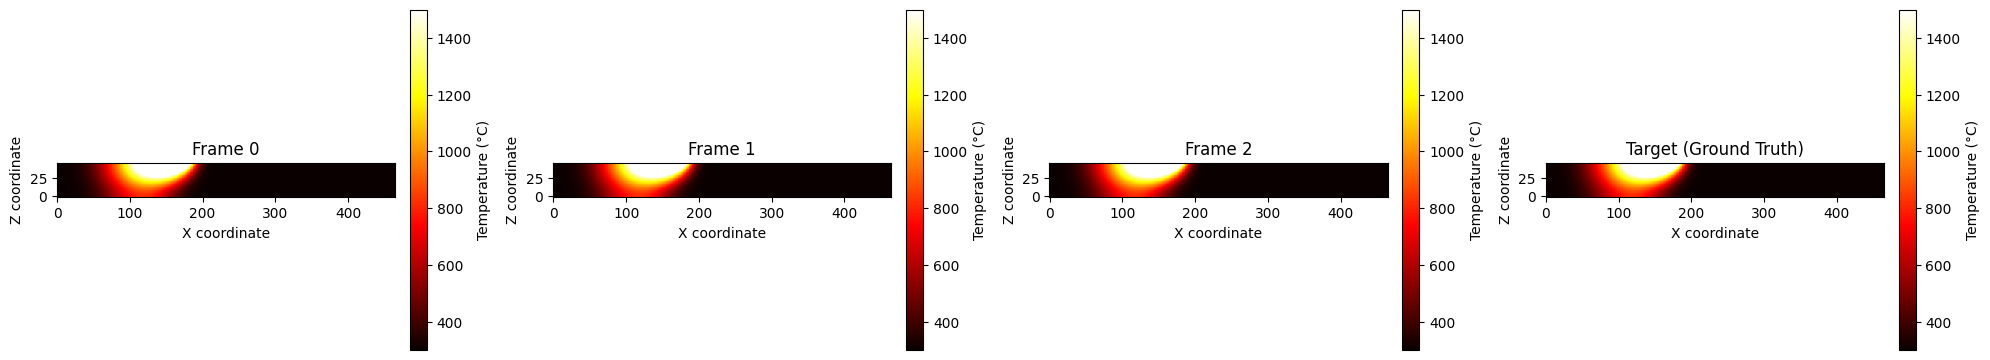


Visualization shows XZ plane (slicing through Y):
  - Frame shape: [X=465, Z=47]
  - X-axis: horizontal scanning direction
  - Z-axis: depth (laser enters from top)
  - Hot regions (yellow/white): >1200°C
  - Warm regions (orange/red): 600-1200°C
  - Cool regions (dark red/black): ~300°C (room temp)


In [135]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize input sequence and target with proper temperature range
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Set consistent color scale for temperature visualization
vmin = 300  # Room temperature
vmax = 1500  # Hot regions

# Plot input sequence frames
for i in range(dataset.sequence_length):
    frame = input_seq[i, 0].numpy()  # Shape: [X, Z] = [465, 47]
    # No rotation needed! X maps to x-axis, Z maps to y-axis
    # Use origin='lower' so Z=0 (surface) is at top after inversion
    im = axes[i].imshow(frame.T, cmap="hot", vmin=vmin, vmax=vmax, aspect='equal', interpolation='nearest')
    axes[i].set_title(f"Frame {i}")
    axes[i].set_xlabel("X coordinate")
    axes[i].set_ylabel("Z coordinate")
    axes[i].invert_yaxis()  # Invert so laser (Z=0) is at top
    plt.colorbar(im, ax=axes[i], label="Temperature (°C)", fraction=0.046, pad=0.04)

# Plot target frame
frame = target[0].numpy()  # Shape: [X, Z]
im = axes[-1].imshow(frame.T, cmap="hot", vmin=vmin, vmax=vmax, aspect='equal', interpolation='nearest')
axes[-1].set_title("Target (Ground Truth)")
axes[-1].set_xlabel("X coordinate")
axes[-1].set_ylabel("Z coordinate")
axes[-1].invert_yaxis()
plt.colorbar(im, ax=axes[-1], label="Temperature (°C)", fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print(f"\nVisualization shows XZ plane (slicing through Y):")
print(f"  - Frame shape: [X={frame.shape[0]}, Z={frame.shape[1]}]")
print(f"  - X-axis: horizontal scanning direction")
print(f"  - Z-axis: depth (laser enters from top)")
print(f"  - Hot regions (yellow/white): >1200°C")
print(f"  - Warm regions (orange/red): 600-1200°C")
print(f"  - Cool regions (dark red/black): ~300°C (room temp)")

## Statistics Across Dataset

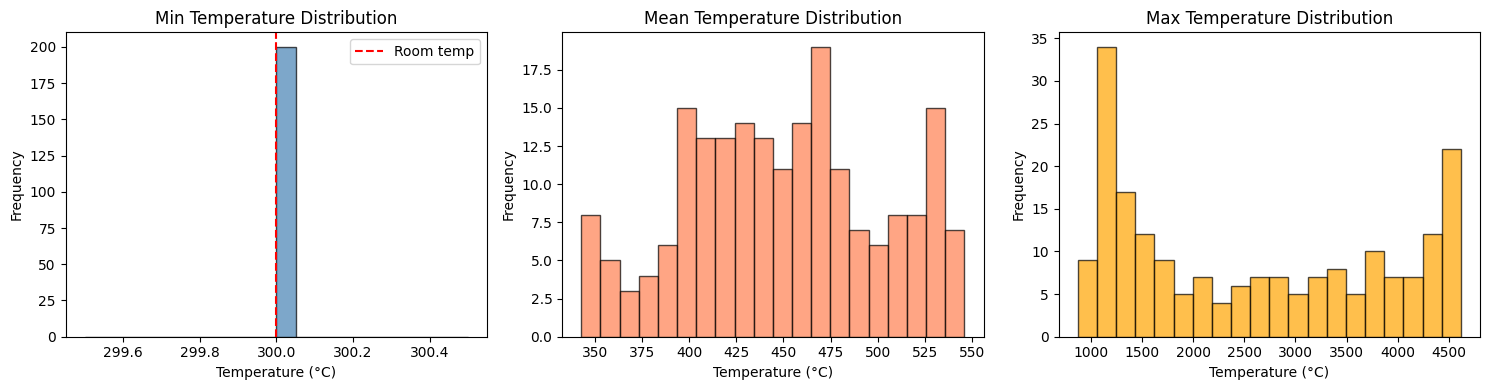


Temperature statistics across 200 samples:
  Global min: 300.0°C
  Global max: 4616.0°C
  Average mean: 450.0°C
  Average max: 2602.3°C


In [100]:
# Compute statistics across samples to understand data distribution
all_min = []
all_max = []
all_mean = []

# Sample from middle of dataset where heating occurs
sample_range = range(400, min(600, len(dataset)))

for i in sample_range:
    seq, tgt = dataset[i]
    all_min.append(seq.min().item())
    all_max.append(seq.max().item())
    all_mean.append(seq.mean().item())

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(all_min, bins=20, edgecolor="black", alpha=0.7, color='steelblue')
axes[0].set_title("Min Temperature Distribution")
axes[0].set_xlabel("Temperature (°C)")
axes[0].set_ylabel("Frequency")
axes[0].axvline(300, color='red', linestyle='--', label='Room temp')
axes[0].legend()

axes[1].hist(all_mean, bins=20, edgecolor="black", alpha=0.7, color='coral')
axes[1].set_title("Mean Temperature Distribution")
axes[1].set_xlabel("Temperature (°C)")
axes[1].set_ylabel("Frequency")

axes[2].hist(all_max, bins=20, edgecolor="black", alpha=0.7, color='orange')
axes[2].set_title("Max Temperature Distribution")
axes[2].set_xlabel("Temperature (°C)")
axes[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

print(f"\nTemperature statistics across {len(sample_range)} samples:")
print(f"  Global min: {np.min(all_min):.1f}°C")
print(f"  Global max: {np.max(all_max):.1f}°C")
print(f"  Average mean: {np.mean(all_mean):.1f}°C")
print(f"  Average max: {np.mean(all_max):.1f}°C")

## Create Animation

In [144]:
from lasernet.visualize import create_animation_frames
from pathlib import Path

# Get a longer sequence for animation (10 consecutive frames)
start_timestep = 3
y_dim_size = 94
slice_index = y_dim_size // 2  # middle slice along Y-axis
start_idx = start_timestep * y_dim_size + slice_index  # calculate sample index
num_frames = 5

# Collect frames
animation_sequence = []
for i in range(start_idx, start_idx + num_frames * y_dim_size, y_dim_size):
    if i >= len(dataset):
        break
    # Get just the first frame from each sample (not the full sequence)
    sample_seq, _ = dataset[i]
    animation_sequence.append(sample_seq[0, 0])  # [X, Z]

# Stack into tensor [T, X, Z]
animation_tensor = torch.stack(animation_sequence)

print(f"Animation sequence shape: {animation_tensor.shape}")
print(f"Creating {len(animation_sequence)} frames...")

# Create animation frames
output_dir = Path("../outputs/animation_frames")
frame_paths = create_animation_frames(
    animation_tensor,
    output_dir=output_dir,
    vmin=300,
    vmax=4600,
    prefix="temp"
)

print(f"\nCreated {len(frame_paths)} frames in {output_dir}")
print(f"First frame: {frame_paths[0]}")
print(f"Last frame: {frame_paths[-1]}")
print(f"\nTo create a video, run:")
print(f"  ffmpeg -framerate 2 -pattern_type glob -i '{output_dir}/temp_*.png' -c:v libx264 -pix_fmt yuv420p temperature_animation.mp4")

Animation sequence shape: torch.Size([5, 465, 47])
Creating 5 frames...

Created 5 frames in ../outputs/animation_frames
First frame: ../outputs/animation_frames/temp_0000.png
Last frame: ../outputs/animation_frames/temp_0004.png

To create a video, run:
  ffmpeg -framerate 2 -pattern_type glob -i '../outputs/animation_frames/temp_*.png' -c:v libx264 -pix_fmt yuv420p temperature_animation.mp4
